Library Import

In [2]:
#System and performance tool
import os
import time

#Data Management
import pandas as pd
import numpy as np

#Visualization tool
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine Learning tool
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# 1.Import Data

In [10]:
# path to data
RAW_DATA_FOLDER = '/Users/yogisharosarumaha/Documents/GitHub/predict_future_sales_kaggle/data/'

In [11]:
#Load Data
import pandas as pd
items               =pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'items.csv'))
item_categories     =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'item_categories.csv'))
shops               =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'shops.csv'))
train_df            =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'sales_train.csv'))
test_df             =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'test.csv'))

In [12]:
#Dataset informations
print('items: ' + str(items.shape))
print()
items.info(null_counts=True)
print()
print('-'*50)
print('item_categories :' + str(item_categories.shape))
print()
item_categories.info(null_counts=True)
print()
print('-'*50)
print('shops :' + str(shops.shape))
print()
shops.info(null_counts=True)

items: (22170, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB

--------------------------------------------------
item_categories :(84, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB

--------------------------------------------------
shops :(60, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):

In [13]:
print('train_df :' + str(train_df.shape) )
print()
train_df.info(null_counts=True)
print('-'*50)
print()
print('test_df :' + str(test_df.shape))
print()
test_df.info(null_counts=True)
print('-'*50)

print('Proportion of unique item in train set : ' + str(train_df.item_id.nunique()) + ' / ' + str(items.item_id.nunique()))
print('Proportion of unique item in test set : ' + str(test_df.item_id.nunique()) + ' / ' + str(items.item_id.nunique()))
print()
print('Proportion of unique shops in train set : ' + str(train_df.shop_id.nunique()) + ' / ' + str(shops.shop_id.nunique()))
print('Proportion of unique shops in test set : ' + str(test_df.shop_id.nunique()) + ' / ' + str(shops.shop_id.nunique()))



train_df :(2935849, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
--------------------------------------------------

test_df :(214200, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
-----------------

Data Overview

In [14]:
print('Train_data Minimum Date: ' + train_df['date'].min())
print('Train_data Maximum Date: ' + train_df['date'].max())

Train_data Minimum Date: 01.01.2013
Train_data Maximum Date: 31.12.2014


# 2. Data Cleaning

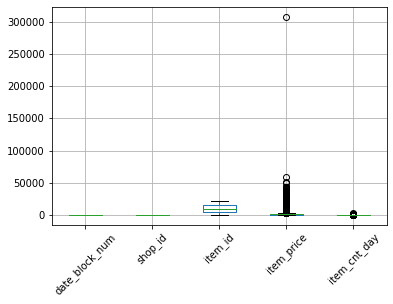

In [15]:
#Display outlier for all variables
#Visible outlier from item_price
train_df.boxplot( rot=45)

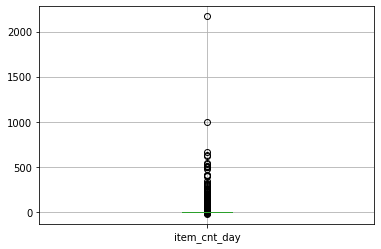

In [16]:
train_df.boxplot(column=['item_cnt_day'])

In [17]:
#Remove outlier based on boxplot
print('Data set size before remove outlier:', train_df.shape)
train_df = train_df[(train_df.item_price < 300000 )& (train_df.item_cnt_day < 1000)]
print('Data set size before remove outlier:', train_df.shape)

Data set size before remove outlier: (2935849, 6)
Data set size before remove outlier: (2935846, 6)


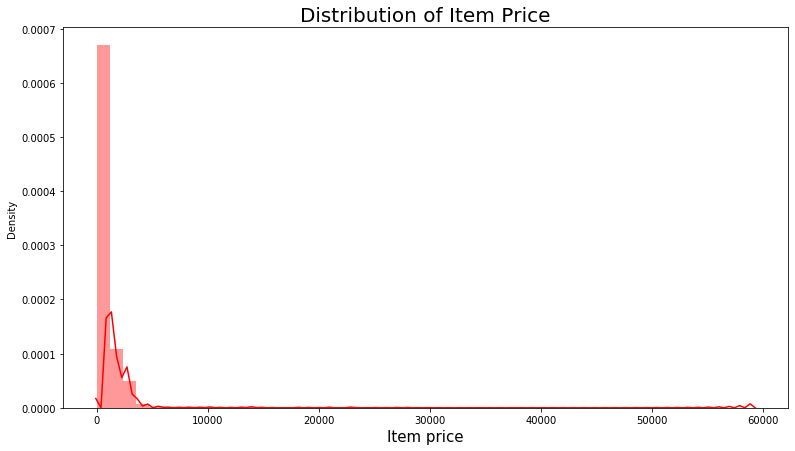

In [18]:
#Display distribution of  item count day
plt.rcParams['figure.figsize'] = (13,7)
sns.distplot(train_df['item_price'], color = 'red')
plt.title('Distribution of Item Price',fontsize=20)
plt.xlabel('Item price',fontsize=15)
plt.ylabel('Density')
plt.show()
# train_df.item_cnt_day.hist(bins=100)
# train_df.item_cnt_day.describe()

In [19]:
#Item price should at least 1
print('Data set size before remove item price 0 cleaning:', train_df.shape)
train_df = train_df.query('item_price > 0')
print('Data set size after remove item price 0 cleaning:', train_df.shape)

Data set size before remove item price 0 cleaning: (2935846, 6)
Data set size after remove item price 0 cleaning: (2935845, 6)


In [20]:
#Display items count of day with negative numbers
train_df[train_df['item_cnt_day'] < 0].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0


In [21]:
#Only get non-negative count of day value
print('Data set size before remove item price 0 cleaning:', train_df.shape)
train_df = train_df.query('item_cnt_day >= 0')
print('Data set size after remove item price 0 cleaning:', train_df.shape)

Data set size before remove item price 0 cleaning: (2935845, 6)
Data set size after remove item price 0 cleaning: (2928489, 6)


# 3. Data Transformation

In [22]:
#Create Date COlumn
train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')

# making a new column month
train_df['month'] = pd.to_datetime(train_df['date'], errors='coerce')

# making a new column year
train_df['year'] = pd.to_datetime(train_df['date'], errors='coerce')

# making a new column week
train_df['week'] =pd.to_datetime(train_df['date'], errors='coerce')

# checking the new columns
train_df.columns


Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'month', 'year', 'week'],
      dtype='object')

In [23]:
train_df.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,week
0,2013-02-01,0,59,22154,999.00,1.0,2013-02-01,2013-02-01,2013-02-01
1,2013-03-01,0,25,2552,899.00,1.0,2013-03-01,2013-03-01,2013-03-01
3,2013-06-01,0,25,2554,1709.05,1.0,2013-06-01,2013-06-01,2013-06-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013-01-15,2013-01-15,2013-01-15
5,2013-10-01,0,25,2564,349.00,1.0,2013-10-01,2013-10-01,2013-10-01


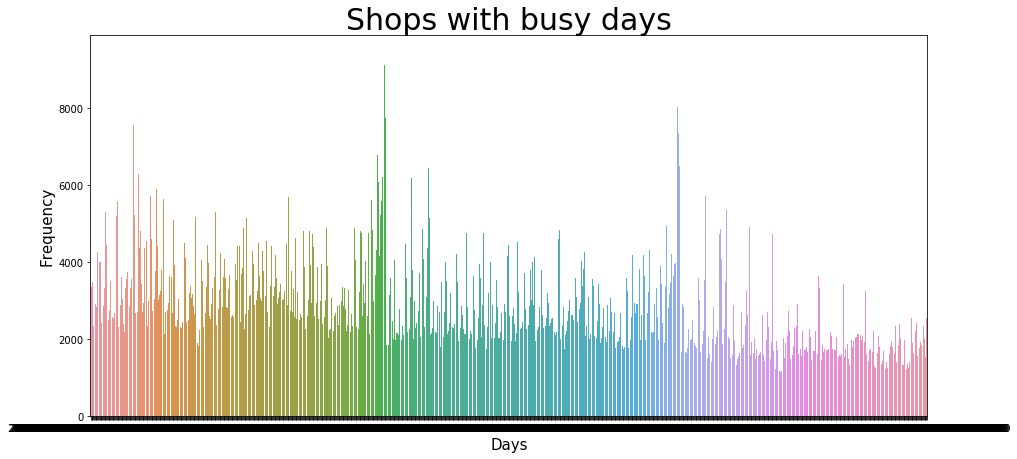

In [24]:
# Days with high demand

plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(train_df['date'])
plt.title('Shops with busy days', fontsize = 30)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

plt.show()

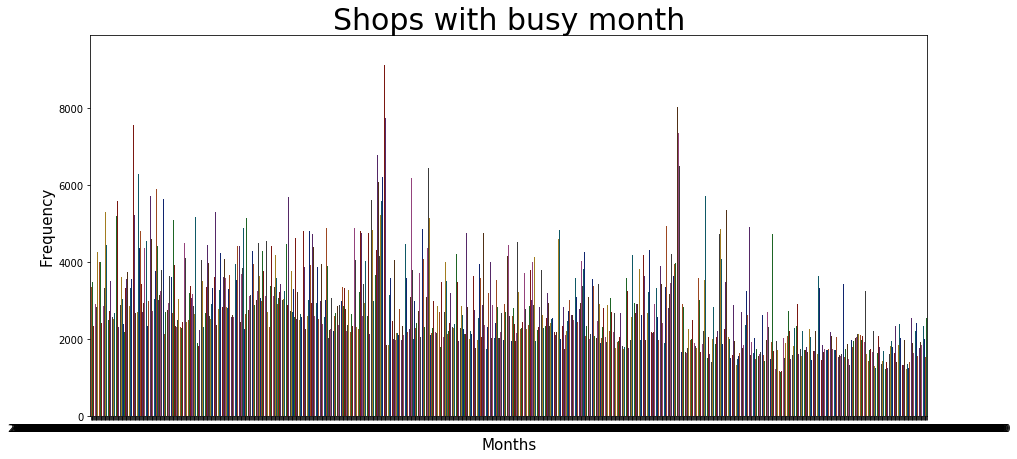

In [25]:
# Months with high demands

plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(train_df['month'], palette = 'dark')
plt.title('Shops with busy month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

plt.show()

In [26]:
# Convert data to Monthly

# Dataset only for monthly data
data = train_df.groupby([train_df['date'].apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()

# specifying the important attributes which we want to add to the data
data = data[['date','item_id','shop_id','item_cnt_day']]

# at last we can select the specific attributes from the dataset which are important 
data = data.pivot_table(index=['item_id','shop_id'], columns = 'date', values = 'item_cnt_day', fill_value = 0).reset_index()

# looking at the newly prepared datset
data.shape

(424097, 38)

In [27]:
# Merge monthly sales data prepared to the test data set

test_df=pd.merge(test_df, data, on = ['item_id', 'shop_id'], how = 'left')

# filling the empty values found in the dataset
test_df.fillna(0, inplace = True)

# checking the dataset
test_df.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Create Training data

x_train = test_df.drop(['2015-10', 'item_id', 'shop_id'], axis = 1)
y_train = test_df['2015-10']

# deleting the first column so that it can predict the future sales data
x_test = test_df.drop(['2013-01', 'item_id', 'shop_id'], axis = 1)

# checking the shapes of the datasets
print("Shape of x_train :", x_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_train.shape)

Shape of x_train : (214200, 36)
Shape of x_test : (214200, 36)
Shape of y_test : (214200,)


In [29]:
# splitting the data into train and valid dataset

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

# checking the shapes
print("Shape of x_train :", x_train.shape)
print("Shape of x_valid :", x_valid.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_valid :", y_valid.shape)

Shape of x_train : (171360, 36)
Shape of x_valid : (42840, 36)
Shape of y_train : (171360,)
Shape of y_valid : (42840,)


# Modeling

In [31]:
from lightgbm import LGBMRegressor

model_lgb = LGBMRegressor( n_estimators=200,
                           learning_rate=0.01,
                           num_leaves=50,
                           colsample_bytree=0.95,
                           subsample=0.80,
                           max_depth=10,
                           reg_alpha=0.4,
                           reg_lambda=0.1,
                           min_split_gain=0.1,
                           min_child_weight=40)
model_lgb.fit(x_train, y_train)

y_pred_lgb = model_lgb.predict(x_test)

# 4.1 Train test val split

In [32]:
# Test set and clip certain range
y_pred_lgb = model_lgb.predict(x_test).clip(0., 20.)

# File for submission
preds = pd.DataFrame(y_pred_lgb, columns=['item_cnt_month'])
preds.to_csv('submission.csv',index_label='ID')